# 50 MeV D on Ta 

This notebook documents the steps taken to calibrate, aquire, and analyze data from activation foils used to unfold the neutron spectrum from 50 MeV D breakup on Ta.  

This Notebook is broken into the following main sections: <br\>
1) Simulated Results <br\>
2) Simulated Unfold <br\>
3) Calibration <br\>
4) Count Plan <br\>
5) Experimental Setup <br\>

The notebook has dependecies on PScripts, which can be cloned from:
https://github.com/jamesbevins/PyScripts

In [1]:
import os
import sys
import peakutils

import pandas as pd
import numpy as np
import copy as cp

from math import sqrt, exp, log
from datetime import datetime
from scipy.optimize import curve_fit
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline

# Path to PyScripts support functions 
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/GeneralNuclear'))
from Counting import parse_spe, simple_peak_counts, germanium_eff_exp, foil_count_time, volume_solid_angle, \
                     optimal_count_plan, germanium_eff_poly, ge_peakfit, get_peak_windows, find_best_fit, \
                     germanium_eff
from BasicNuclearCalcs import decay, production_decay, get_decay_const, fractional_solid_angle
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from Stats import red_chisq, curve_fit_error4

## Simulated Results

### MCNP

The experimental configuration was simulated in MCNP to get the expected reaction rates.  The Meulder's deuterons on 197Au was used as the source, and the foil pack was suspended center beam 34.62 cm from the wall.

The results are located at <path>\Dropbox\UCB\Research\ETAs\88Inch\Data\Simulated\Activation\16MeVTa\Model

They are sumarized at:

In [2]:
simPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Simulated/Activation/50MeVTa/50MeVTaFoils.xlsx"

## Simulated Unfold

Unfold of the MCNP results to test the theroretical ability to unfold given a set of reaction channels.  

## Calibration

### Import source data

Calibration was performed using Cs137, Co60, Eu 152, Am241, and Ba133 sources. The lines used for energy and efficiency calibration are:

#### Position 18 cm

Source   | Line (keV)| BR [%] | Time  | Filename
-------- |:---------:|:------:|:-----:|:----------------:
Cs137    |661.657    |85.10   |0733   |Cs137_18_0737_26Feb17
Co60     |1173.23    |99.85   |0746   |Co60_18_0759_26Feb17
Co60     |1332.49    |99.98   |0746   |Co60_18_0759_26Feb17
Am241    |59.54      |2.14    |0804   |Am241_18_0737_26Feb17
Ba133    |80.9979    |32.9    |0850   |Ba133_18_0921_26Feb17
Ba133    |276.40     |7.16    |0850   |Ba133_18_0921_26Feb17
Ba133    |302.85     |18.34   |0850   |Ba133_18_0921_26Feb17
Ba133    |356.01     |62.05   |0850   |Ba133_18_0921_26Feb17
Eu152    |121.70     |20.56   |0936   |Eu152_18_0737_26Feb17
Eu152    |244.70     |5.44    |0936   |Eu152_18_0737_26Feb17
Eu152    |344.29     |7.42    |0936   |Eu152_18_0737_26Feb17
Eu152    |778.90     |3.61    |0936   |Eu152_18_0737_26Feb17
Eu152    |964.06     |10.46   |0936   |Eu152_18_0737_26Feb17
Eu152    |1112.08    |9.85    |0936   |Eu152_18_0737_26Feb17
Eu152    |1408.01    |15.04   |0936   |Eu152_18_0737_26Feb17

#### Position 1 cm

The drawer was a little loose in the stack.  It was pushed to back right for repeatibility.

Source   | Line (keV)| BR [%] | Time  | Filename
-------- |:---------:|:------:|:-----:|:----------------:
Cs137    |661.657    |85.10   |1013   |Cs137_1_1015_26Feb17
Co60     |1173.23    |99.85   |1018   |Co60_1_1020_26Feb17
Co60     |1332.49    |99.98   |1018   |Co60_1_1020_26Feb17
Am241    |59.54      |2.14    |1024   |Am241_1_1025_26Feb17
Ba133    |80.9979    |32.9    |1029   |Ba133_1_0921_26Feb17
Ba133    |276.40     |7.16    |1029   |Ba133_1_0921_26Feb17
Ba133    |302.85     |18.34   |1029   |Ba133_1_0921_26Feb17
Ba133    |356.01     |62.05   |1029   |Ba133_1_0921_26Feb17
Eu152    |121.70     |20.56   |1036   |Eu152_1_1048_26Feb17
Eu152    |244.70     |5.44    |1036   |Eu152_1_1048_26Feb17
Eu152    |344.29     |7.42    |1036   |Eu152_1_1048_26Feb17
Eu152    |778.90     |3.61    |1036   |Eu152_1_1048_26Feb17
Eu152    |964.06     |10.46   |1036   |Eu152_1_1048_26Feb17
Eu152    |1112.08    |9.85    |1036   |Eu152_1_1048_26Feb17
Eu152    |1408.01    |15.04   |1036   |Eu152_1_1048_26Feb17

This data, along with the initial activity and decay information, is also located in the excel file located here:

In [3]:
calibSourcesPath = 'CalibrationSources.xlsx'

Import the source and activity data and format for later analysis:

In [17]:
sources = pd.read_excel(calibSourcesPath, "Sources")
sources.columns = ['source', 'initActivity', 'initActRelUncert', 'initDate', 'halfLife']
sources.index = sources.source
del sources['source']
sources['initDate'] = pd.to_datetime(sources['initDate'])
sources['measDate'] = 0     

print "The calibration source data used: \n\n", sources

The calibration source data used: 

        initActivity  initActRelUncert   initDate     halfLife  measDate
source                                                                  
Am241         10.300           0.01165 1970-01-01  13644204000         0
Eu152          1.062           0.01165 2009-01-01    426326180         0
Co60           1.007           0.01165 2009-01-01    166344192         0
Cs137          1.042           0.01165 2009-01-01    948723200         0
Ba133          1.078           0.01165 2009-01-01    332778540         0


Import the calibration line and branching ratio data:

In [18]:
lines = pd.read_excel(calibSourcesPath,"Lines")
lines.columns=['isotope','line','branchingRatio']
print "The calibration peak data used: \n\n", lines

The calibration peak data used: 

      isotope       line  branchingRatio
0   Cs137       661.6570        0.851000
1   Co60       1173.2300        0.998500
2   Co60       1332.4900        0.999826
3   Ba133        80.9979        0.329000
4   Ba133       276.4000        0.071600
5   Ba133       302.8500        0.183400
6   Ba133       356.0100        0.620500
7   Eu152       121.7000        0.285300
8   Eu152       244.7000        0.075500
9   Eu152       344.2900        0.265900
10  Eu152       778.9000        0.129300
11  Eu152       964.0600        0.145100
12  Eu152      1112.0800        0.136700
13  Eu152      1408.0100        0.208700


### Perform software energy calibration

The energy calibration was performed using GammaVision.

[insert calibration procedure here]

### Read in the calibration data

Read in all of the data taken for calibration.  

This procedure assumes: <br/>
1) That there is a folder with only calibration data in the format "isotope_position_anything.Spe".  For example, a valid naming convention is "Co60_1_8Feb17.Spe".  The first field is used to compare against the imported lines, and the second field is to build a location dependent calibration. <br/>
2) Only calibration data lives in the calibration path specified.  <br/>
3) That the calibration order listed above in the table was followed. <br/>

The path the calibration data is:

In [19]:
calibDataPath = '/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/Activation/50MeVTa/CalibrationData/'

# Variables to allow for multiple positions to be handled at once
posSet = False
posUsed = []

# Storage for parameters that vary by position
liveTime = {}
eCalibParams = {} #ax^2 +bx + c stored as (a,b,c)
data = {}

# Loop over all files
for filename in os.listdir(calibDataPath):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time, measDate, a, b, c, tmpData) = parse_spe(calibDataPath+filename)
        
        # Determine position, update data structures if necessary, and store data
        position = int(name.split('_')[1])
        if position not in posUsed:
            posUsed.append(position)
            liveTime[position] = {}
            data[position] = tmpData
            data[position].columns = [name.split('_')[0]]
        else: 
            data[position].loc[:,name.split('_')[0]] = tmpData['counts']
        sources.at[name.split('_')[0], 'measDate'] = measDate
        liveTime[position][name.split('_')[0]] = time
        if name.split('_')[0] == "Eu152":
            eCalibParams[position] = (a, b, c)
                
for p in posUsed:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime[p]
    print "Energy Calibration: {}*ch^2 + {} * ch + {}".format(eCalibParams[p][0],eCalibParams[p][1],eCalibParams[p][2])
    print data[p].head(3)

Processing: Cs137_1_1015_26Feb17.Spe
Processing: Eu152_18_1002_26Feb17.Spe
Processing: Am241_18_0808_26Feb17.Spe
Processing: Co60_1_1020_26Feb17.Spe
Processing: Am241_1_1025_26Feb17.Spe
Processing: Co60_18_0759_26Feb17.Spe
Processing: Cs137_18_0737_26Feb17.Spe
Processing: Eu152_1_1048_26Feb17.Spe
Processing: Ba133_1_1034_26Feb17.Spe
Processing: Ba133_18_0921_26Feb17.Spe

Position = 1 cm
LiveTime: {'Cs137': 97.0, 'Co60': 137.0, 'Ba133': 280.0, 'Eu152': 613.0, 'Am241': 59.0}
Energy Calibration: 3.28854e-08*ch^2 + 0.383693 * ch + 0.174637
      Cs137      Co60     Am241     Eu152     Ba133
0         0         0         0         0         0
1         0         0         0         0         0
2         0         0         0         0         0

Position = 18 cm
LiveTime: {'Am241': 230.0, 'Co60': 997.0, 'Ba133': 1845.0, 'Cs137': 278.0, 'Eu152': 2136.0}
Energy Calibration: 6.241566e-08*ch^2 + 0.3835831 * ch + 0.1460746
      Eu152     Am241      Co60     Cs137     Ba133
0         0         0

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>
2) A linear interpolation of the continuum is sufficient.  <br/>

There is an alternate, more sophisticated procedure immediately following this set of code.  This portion of code is redunant, but kept for now. If this peak fitting method is preferred, then change the cell to code and do not run the next peak fitting routine.   

# Create a dictionary of data frames to store each of the positional information
peakData = {}

for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    for column in data[p]:
        
        # Find the peaks 
        channels = np.asarray(data[p].index)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        counts = np.asarray(data[p][column]).astype(float)
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Counts     Area"      
        for i in range(len(lines['line'])):
            for e, c, pk in zip(energy[peaks], counts[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert']) = simple_peak_counts(channels, counts, pk)
                    print "{:.2f}   {:.0f}   {:.2f}".format(e, c, lines.at[i, 'measuredCounts'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>  


------------------------
Position = 1 cm
------------------------

Cs137 
Energy  Peak Area
661.76   111265   333




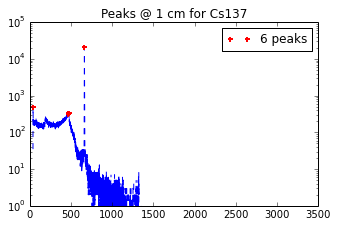


Co60 
Energy  Peak Area
1173.05   41610   203
1332.37   37206   192




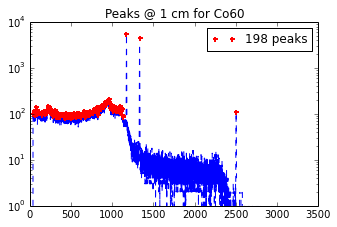


Am241 
Energy  Peak Area




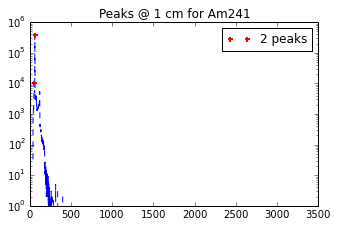


Eu152 
Energy  Peak Area
121.81   538366   733
244.60   75632   275
344.37   276403   525
778.82   62580   250
963.84   48237   219
1112.01   41007   202
1408.00   50990   225




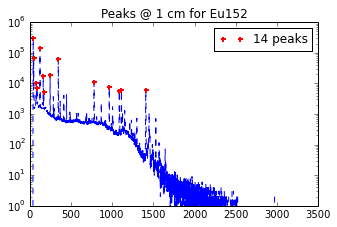


Ba133 
Energy  Peak Area
81.14   292779   541
276.45   27183   164
302.93   80619   283
355.89   211441   459




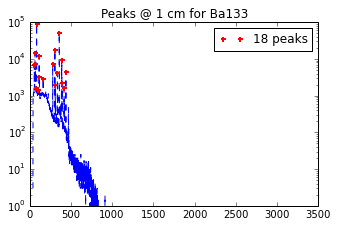

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Cs137   661.6570        0.851000          111265         333
1     Co60  1173.2300        0.998500           41610         203
2     Co60  1332.4900        0.999826           37206         192
3    Ba133    80.9979        0.329000          292779         541
4    Ba133   276.4000        0.071600           27183         164
5    Ba133   302.8500        0.183400           80619         283
6    Ba133   356.0100        0.620500          211441         459
7    Eu152   121.7000        0.285300          538366         733
8    Eu152   244.7000        0.075500           75632         275
9    Eu152   344.2900        0.265900          276403         525
10   Eu152   778.9000        0.129300           62580         250
11   Eu152   964.0600        0.145100           48237         219
12   Eu152  1112.0800        0.136700           41007         202
13   Eu152  1408.0100        0.208700           50990         225

---------

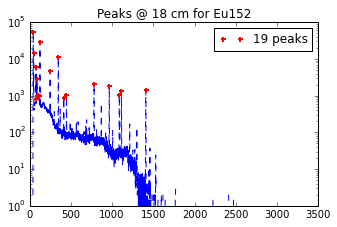


Am241 
Energy  Peak Area




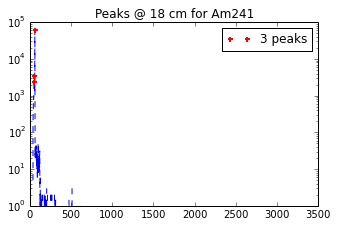


Co60 
Energy  Peak Area
1173.34   14034   118
1332.31   12880   113




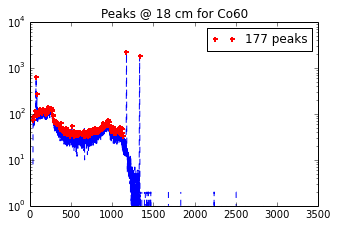


Cs137 
Energy  Peak Area
661.63   12764   112




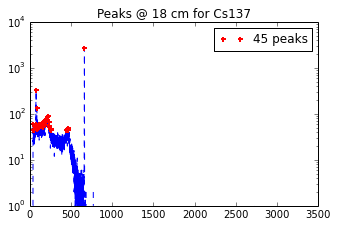


Ba133 
Energy  Peak Area
81.08   87810   296
276.36   17924   133
302.83   24912   157
356.16   73394   270




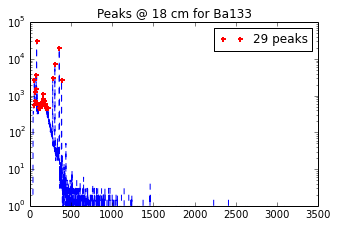

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Cs137   661.6570        0.851000           12764         112
1     Co60  1173.2300        0.998500           14034         118
2     Co60  1332.4900        0.999826           12880         113
3    Ba133    80.9979        0.329000           87810         296
4    Ba133   276.4000        0.071600           17924         133
5    Ba133   302.8500        0.183400           24912         157
6    Ba133   356.0100        0.620500           73394         270
7    Eu152   121.7000        0.285300           86447         294
8    Eu152   244.7000        0.075500           16432         128
9    Eu152   344.2900        0.265900           41214         203
10   Eu152   778.9000        0.129300           10371         101
11   Eu152   964.0600        0.145100            9916          99
12   Eu152  1112.0800        0.136700            8406          91
13   Eu152  1408.0100        0.208700           10488         102


In [20]:
# Create a dictionary of data frames to store each of the positional information
peakData = {}

for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    
    # Update dataframe to store calculated peak information
    lines['measuredCounts'] = 0     
    lines['measUncert'] = 0
    
    for column in data[p]:    
        # Find the peaks and set the windows
        channels = np.asarray(data[p].index)
        counts = np.asarray(data[p][column]).astype(float)
        energy = eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        peaks = peakutils.indexes(counts, thres=0.015, min_dist=10)
        windows = get_peak_windows(peaks)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Peak Area"      
        for i in range(len(lines['line'])):
            for e, pk in zip(energy[peaks], peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 0.5 and data[p][column].name.strip() == lines['isotope'][i].strip():
                    pkChannels = channels[windows[pk][0]:windows[pk][1]]
                    pkCounts = counts[windows[pk][0]:windows[pk][1]]
                    (lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'], redChiSq) = ge_peakfit(pkChannels, 
                                                                                                      pkCounts)
                    
                    print "{:.2f}   {:.0f}   {:.0f}".format(e, lines.at[i, 'measuredCounts'], lines.at[i, 'measUncert'])
            lines.at[i, 'isotope'] = lines.at[i, 'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig = pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p] = cp.deepcopy(lines)

In [ ]:
####TMP#### - Can remove once satisfied that peak fitting is working correctly
# Find the peaks 
channels = np.asarray(data[18].index)
energy = eCalibParams[18][2]+eCalibParams[18][1]*channels+eCalibParams[18][0]*channels**2
counts = np.asarray(data[18]['Eu152']).astype(float)
peaks = peakutils.indexes(counts, thres=0.015, min_dist=10)
print peaks

window = get_peak_windows(peaks)
#peaks = [210, 720, 927] # Ba133
#peaks = [317, 637, 896, 2028, 2510, 2897, 3666] #Eu152@1
#peaks = [317, 637, 897, 2028, 2510, 2897, 3666] #Eu152@10
peaks = [317, 638, 897, 2029, 2511, 2897, 3668] #Eu152@18
peaks = [638] #Eu152@18
#peaks = [3055, 3469]

# Loop over all identified peaks to compare against calibration points loaded previously
for pk in peaks:
    pkChannels = channels[window[pk][0]:window[pk][1]]
    pkCounts = counts[window[pk][0]:window[pk][1]]
    (peakCounts, peakStd, redChiSq) = ge_peakfit(pkChannels, pkCounts)
    
    print "{:.2f}   {:.2f}   {:.2f}".format(energy[pk], peakCounts, peakStd)

In [ ]:
## Propogation of fitting error?
import sys
import os
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from Math import gaussScalar
#from sympy import symbols, diff
import theano
#x, a, b, c = symbols('x a b c')
#print diff(gaussScalar(x, a, b, c), x)

### Calculate the current activity

Using the data read in from the .spe files, calculate the current activity at the time of the measurement.  

NOTE:  There is a mix in the activity units.  The initActivity is in $\mu$Ci as reported on the source, whereas the curActivity in is Bq.

In [21]:
sources['curActivity'] = 0
for src in sources.index:
    sources.at[src, 'curActivity'] = decay(sources.at[src, 'halfLife'],sources.at[src, 'initActivity'], \
                                        (sources.at[src, 'measDate']-sources.at[src, 'initDate']).total_seconds())
print sources   

        initActivity  initActRelUncert   initDate     halfLife  \
source                                                           
Am241         10.300           0.01165 1970-01-01  13644204000   
Eu152          1.062           0.01165 2009-01-01    426326180   
Co60           1.007           0.01165 2009-01-01    166344192   
Cs137          1.042           0.01165 2009-01-01    948723200   
Ba133          1.078           0.01165 2009-01-01    332778540   

                   measDate  curActivity  
source                                    
Am241   2017-02-26 10:24:01       353351  
Eu152   2017-02-26 10:36:42        25859  
Co60    2017-02-26 07:43:05        12751  
Cs137   2017-02-26 08:11:11        31946  
Ba133   2017-02-26 08:50:46        23336  


### Calculate absolute effficiency

Determine an absolute efficiency curve for each position by curve fitting the experimental data. The germanium_eff_exp function has support for propogation of error, but the germanium_eff, or germanium_eff_poly are also available.  

NOTE: The choice of which functions to onsider can be set with the functions list.

NOTE: The uncertainty only currently captures the uncertainity in the counts and initial activity.  The uncertaities in BR, half lives, and measurement time are sufficiently small that they can be ignored, but there is uncertainty associated with the fit of the peak that is not captured if germanium_eff_exp is not used.  

The fitting function was: germanium_eff_exp
The curve fitting parameters at 1 cm are: [  9.38373762e-06   2.02939360e+00   5.55723889e-01   5.81001820e-01]
  with standard deviations at 1 cm of: [  1.47729596e-05   2.06636983e-01   5.46477170e-02   2.20700395e-02]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Cs137   661.6570    2.637046e+06       0.042193   0.000492
1     Co60  1173.2300    1.744267e+06       0.023855   0.000278
2     Co60  1332.4900    1.746583e+06       0.021302   0.000248
3    Ba133    80.9979    2.149712e+06       0.136195   0.001587
4    Ba133   276.4000    4.678401e+05       0.058103   0.000677
5    Ba133   302.8500    1.198350e+06       0.067275   0.000784
6    Ba133   356.0100    4.054397e+06       0.052151   0.000608
7    Eu152   121.7000    4.522452e+06       0.119043   0.001387
8    Eu152   244.7000    1.196793e+06       0.063196   0.000736
9    Eu152   344.2900    4.214932e+06       0.065577   0.000764
10   Eu152   778.9000    2.049

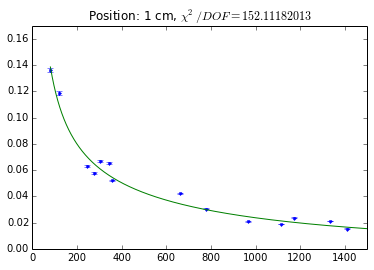

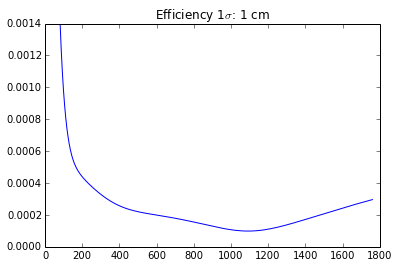

The fitting function was: germanium_eff
The curve fitting parameters at 18 cm are: [ 0.00470408  0.00283246  0.04348764  0.0017572 ]
  with standard deviations at 18 cm of: [  1.20860300e-04   8.38403905e-05   1.45046831e-03   1.14148401e-04]

   isotope       line  expectedCounts  absEfficiency  effUncert
0    Cs137   661.6570    7.557721e+06       0.001689   0.000020
1     Co60  1173.2300    1.269368e+07       0.001106   0.000013
2     Co60  1332.4900    1.271053e+07       0.001013   0.000012
3    Ba133    80.9979    1.416507e+07       0.006199   0.000072
4    Ba133   276.4000    3.082732e+06       0.005814   0.000068
5    Ba133   302.8500    7.896272e+06       0.003155   0.000037
6    Ba133   356.0100    2.671558e+07       0.002747   0.000032
7    Eu152   121.7000    1.575850e+07       0.005486   0.000064
8    Eu152   244.7000    4.170229e+06       0.003940   0.000046
9    Eu152   344.2900    1.468694e+07       0.002806   0.000033
10   Eu152   778.9000    7.141863e+06       0.001452

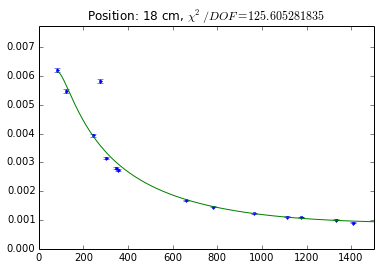

In [22]:
from Counting import germanium_eff
functions=[germanium_eff, germanium_eff_exp]#, germanium_eff_poly]
absEffParams = {}
absEffCov = {}
fitFunc = {} 

for p in posUsed:
    peakData[p]['expectedCounts'] = 0.0
    peakData[p]['absEfficiency'] = 0.0
    peakData[p]['effUncert'] = 0.0
    
    # Calculate the absolute efficiency and uncertainty
    for index, row in peakData[p].iterrows():
        peakData[p].at[index, 'expectedCounts'] = sources.at[peakData[p].at[index, 'isotope'], 'curActivity'] \
                                               * peakData[p].at[index, 'branchingRatio'] \
                                               * liveTime[p][peakData[p].at[index, 'isotope']]
        peakData[p].at[index, 'absEfficiency'] = float(peakData[p].at[index, 'measuredCounts']) \
                                               / float(peakData[p].at[index, 'expectedCounts'])
        peakData[p].at[index, 'effUncert'] = peakData[p].at[index, 'absEfficiency'] * \
                                           sqrt((peakData[p].at[index, 'measUncert'] \
                                           / peakData[p].at[index, 'measuredCounts'])**2 \
                                               + sources.at[peakData[p].at[index, 'isotope'], 'initActRelUncert']**2)
    
    # Fit the data for the current position by finding best fitting routine
    (fitFunc[p], absEffParams[p], absEffCov[p], redChiSq) = find_best_fit(*functions,
                                                     xdata=peakData[p]['line'], ydata=peakData[p]['absEfficiency'],
                                                     sigma=peakData[p]['effUncert'], absolute_sigma=True)
    
    # Output the results
    try:
        print 'The fitting function was: {}'.format(fitFunc[p].__name__)
        print 'The curve fitting parameters at {} cm are: {}'.format(p, absEffParams[p])
        print '  with standard deviations at {} cm of: {}\n'.format(p, np.sqrt(np.diag(absEffCov[p])))
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]

        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))

        #Plot the fit
        xList = np.arange(min(peakData[p]['line']), 1.25*max(peakData[p]['line']), 1)
        yList = map(lambda y: fitFunc[p](y, *absEffParams[p]), xList)
        pyplot.plot(xList, yList)
        pyplot.show()

        #Plot the error
        if fitFunc[p] == germanium_eff_exp:
            pyplot.title('Efficiency 1$\sigma$: {} cm'.format(p))
            xList = np.arange(min(peakData[1]['line']), 1.25*max(peakData[1]['line']), 1)
            yList = map(lambda y: curve_fit_error4(fitFunc[p], np.insert(absEffParams[p], 0, y), y*0.001, 
                                                   absEffCov[p]), xList)
            pyplot.plot(xList, yList)
            pyplot.show()
    except AttributeError:
        print 'No fit was found'
        print peakData[p][['isotope', 'line', 'expectedCounts', 'absEfficiency', 'effUncert']]
        
        #Plot the Data
        pyplot.axis([0, 1500, 0, 1.25*max(peakData[p]['absEfficiency'])])
        pyplot.errorbar(peakData[p]['line'], peakData[p]['absEfficiency'], peakData[p]['effUncert'], fmt='.')
        pyplot.title('Position: {} cm, $\chi^2/DOF={}$'.format(p, redChiSq))
        pyplot.show()

## Count Plan

Develop a count plan based on the planned irradiation. This assumes that you have a priori abs effeciency calibration parameters for the position of interest. 

### Experimental parameters

Specifies experimental parameters for the beam and counting facility used.

runTime = the beam irradiation time in s

transitTime = the minimum time to counting of the first foil in s

background = the background rate at the peak of interest in counts/s

detR = radius of the detector in cm

In [48]:
runTime = 3600*2+1200
transitTime = 335

background = 0.01
detR = 3.245

### Read in Simulation data

Read from the designated file path.  Manipulate the file to build a dataframe with the information needed for the count plan.  

In [49]:
simFoilParams = pd.read_excel(simPath)

# Delete unneccesary columns for readability and make the index the reactant
simFoilParams.index = simFoilParams.Rx
del simFoilParams['Rx']
del simFoilParams['Thickness [cm]']
del simFoilParams['Density']
del simFoilParams['AW']
del simFoilParams['Lambda [s^-1]']

# Rename columns for ease of access and add in the statistics column
simFoilParams.columns = ['foil', 'product', 'gammaEnergy', 'br', 'relStat', 'det2FoilDist', 'normalization', 'rxRate',
                         'rxRateSigma', 'foilR','weightFrac', 'volume', 'halfLife']

# Put branching ratios in fractional form
simFoilParams['br'] = simFoilParams['br']/100.

# Calculate the activity following transit time decay for each rx; delete columns no longer needed
simFoilParams['initActivity'] = 0.0
simFoilParams['activityUncert'] = 0.0
for ind in simFoilParams.index:
    simFoilParams.at[ind,'initActivity'] = production_decay(simFoilParams.at[ind, 'halfLife'], 0, runTime, \
                                                    simFoilParams.at[ind, 'rxRate'], \
                                                    simFoilParams.at[ind, 'normalization'], \
                                                    simFoilParams.at[ind, 'volume'], transitTime)\
                                                    *get_decay_const(simFoilParams.at[ind,'halfLife'])\
                                                    *simFoilParams.at[ind,'br']
    simFoilParams.at[ind,'activityUncert'] = simFoilParams.at[ind, 'initActivity']*simFoilParams.at[ind, 'rxRateSigma']
del simFoilParams['rxRate']
del simFoilParams['normalization']
del simFoilParams['volume']
del simFoilParams['rxRateSigma']

print simFoilParams

                foil product  gammaEnergy      br  relStat  det2FoilDist  \
Rx                                                                         
27Al(n,p)        AlP    Mg27      843.760  0.7180    0.010             1   
115In(n,n')18  InN18  In115M      336.241  0.4580    0.010            18   
115In(n,n')       In  In115M      336.241  0.4580    0.010             1   
27Al(n,a)18    AlA18    Na24     1368.630  0.9999    0.015            18   
27Al(n,a)        AlA    Na24     1368.630  0.9999    0.010             1   
90Zr(n,2n)18    Zr18    Zr89      909.150  0.9904    0.010            18   
90Zr(n,2n)        Zr    Zr89      909.150  0.9904    0.010             1   
58Ni(n,2n)        Ni    Ni57     1378.000  0.8170    0.025             1   

               foilR  weightFrac   halfLife  initActivity  activityUncert  
Rx                                                                         
27Al(n,p)        2.5    1.000000     567.48   1130.687325        1.582962  
115In(n,n')

In [50]:
(countDF,countOrder,countTime) = optimal_count_plan(simFoilParams, handleTime=75, detR=detR,  background=background, 
                                                    units='Bq', toMinute = True, 
                                                    funcDict=fitFunc, funcParamDict=absEffParams )
print 'Total count time = {:2e} hrs\n'.format(countTime/3600)
print 'The order of counting is: {}\n'.format(countOrder)
for ind in countDF.index:
    print "{:15s} {:4.0f} min".format(ind, countDF.at[ind,"countTime"]/60)

Total count time = 2.608333e+01 hrs

The order of counting is: (u'AlP', u'InN18', u'In', u'AlA18', u'Ni', u'AlA', u'Zr18', u'Zr')

27Al(n,p)          8 min
115In(n,n')18    164 min
115In(n,n')       12 min
27Al(n,a)18      532 min
58Ni(n,2n)        27 min
27Al(n,a)         81 min
90Zr(n,2n)18     706 min
90Zr(n,2n)        35 min


Assuming 1 hr 45 min at 2 $\mu$A. 1.5% on Al(n,a) @ 18 
Total count time = 5.161667e+01 hrs

The order of counting is: (u'AlP', u'In', u'InN18', u'AlA18', u'AlA', u'Zr18', u'Zr')

27Al(n,p)         13 min
115In(n,g)        78 min
115In(n,n')       78 min
115In(n,n')18    332 min
27Al(n,a)18     1187 min
27Al(n,a)        231 min
90Zr(n,2n)18    1197 min
90Zr(n,2n)        59 min

Assuming 1 hr 45 min at 2 $\mu$A. 1.5% on Al(n,a) @ 18; added Ni (n,2n) @ 2.5%
Total count time = 5.273333e+01 hrs

The order of counting is: (u'AlP', u'In', u'InN18', u'AlA18', u'AlA', u'Ni', u'Zr18', u'Zr')

27Al(n,p)         13 min
115In(n,g)        78 min
115In(n,n')       78 min
115In(n,n')18    332 min
27Al(n,a)18     1187 min
27Al(n,a)        231 min
58Ni(n,2n)        54 min
90Zr(n,2n)18    1209 min
90Zr(n,2n)        60 min


### NOTES:

1) Ni58(n,2n)Ni57 channel will not be clean.  There will be contributions from Ni60(n,4n)Ni57 (threshold 33.15 MeV) and Ni61(n,5n)Ni57 (threshold 41.09 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
2) Ni58(n,p)Co58 channel will not be clean.  There will be contributions from Ni60(n,2np)Co58 (threshold 20.32 MeV), Ni61(n,3np)Co58 (threshold 28.27 MeV), and Ni62(n,4np)Co58 (threshold 39.03 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>
3) Zr90(n,2n)Zr89 channel will not be clean.  There will be contributions from Zr91(n,3n)Zr89 (threshold 19.38 MeV), Zr92(n,4n)Zr89 (threshold 28.80 MeV), and Zr94(n,6n)Zr89 (threshold 43.21 MeV) channels.  Unfortunatetly, nuclear data does not exist for these channels. <br/>

## Experimental Setup

Counted each foil to verify that there was not residual activity.  

NOTE: Foil drawer has some wiggle room in the stack.  It was pushed all the way back and to the right.  This is not quite centered on the detector, but it is repeatable. The foil itself also doesn't quite fit, so it was ensured that the back edge was in the inset for repeatabiility.  

Zr4 0825 Zr4_1_Background_0831_27Feb17
Al4 0831 Al4_1_Background_0836_27Feb17
In4 0838 Ni4_1_Background_0843_27Feb17
Ni4 0844 Ni4_1_Background_0849_27Feb17

Foil was placed at (65.5 cm, 0 cm, -1 cm)

### Beam On

Start time: 0949:55
Current Integrator: 0
Stop Time:
Current Integrator: 

NOTE: First minute of current monitor calibration data is off. It should read 2 $\mu$A, but it reads a little higher. The recalibration was performed ~1 minute in.  

At ~1003 the beam was stopped because the radiation levels on the roof were too high. At ~1041, the beam was turned on at 1 $\mu$A and adjusted downward until safe levels were reached.  It went down to ~650 nA at 1052.  At 1102, approval was received to go back to 2 $\mu$A.  

5:35 delay 

## Experimental Analysis

In [ ]:
eff=germanium_eff_exp(511.0)
std=curve_fit_error4(germanium_eff_exp, np.insert(absEffParams[p], 0, 511), 511*0.001, absEffCov[p])
print "At {} keV, the efficiency is {} +/- {}%".format(511,eff*100,std*100)